In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
import time
import copy
from tqdm import tqdm

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"🔥 Đang chạy trên thiết bị: {device}")

🔥 Đang chạy trên thiết bị: cuda:0


In [2]:
DATA_DIR = '/kaggle/input/dataset-mat-cat' 

# Định nghĩa các phép biến đổi ảnh 
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),      # ResNet yêu cầu ảnh 224x224
        transforms.RandomHorizontalFlip(),  # Lật ảnh ngẫu nhiên 
        transforms.RandomRotation(10),      # Xoay nhẹ +/- 10 độ
        transforms.ColorJitter(brightness=0.2, contrast=0.2), # Chỉnh sáng tối
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Chuẩn hóa theo ImageNet
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x])
                  for x in ['train', 'valid']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
               for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

print(f"✅ Tìm thấy {len(class_names)} cảm xúc: {class_names}")
print(f"📊 Số lượng ảnh Train: {dataset_sizes['train']} | Valid: {dataset_sizes['valid']}")

✅ Tìm thấy 8 cảm xúc: ['anger', 'content', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
📊 Số lượng ảnh Train: 11703 | Valid: 1902


In [7]:
print("\n🏗️ Đang tải model ResNet50 Pretrained...")
model = models.resnet50(pretrained=True)

# Đóng băng các lớp đầu 
for param in model.parameters():
    param.requires_grad = False

# Thay thế lớp cuối cùng (Fully Connected) để output ra 8 lớp cảm xúc
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.4), # Tránh học vẹt
    nn.Linear(512, len(class_names)) # Output ra 8 lớp
)

model = model.to(device)


🏗️ Đang tải model ResNet50 Pretrained...


In [8]:
criterion = nn.CrossEntropyLoss()
# Chỉ train các tham số của lớp cuối cùng (model.fc)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [9]:
def train_model(model, criterion, optimizer, num_epochs=20):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'resnet50_emotion_best.pth')
                print("🔥 Tìm thấy model tốt hơn! Đã lưu.")

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

In [10]:
model_ft = train_model(model, criterion, optimizer, num_epochs=25)


Epoch 1/25
----------


train: 100%|██████████| 366/366 [01:04<00:00,  5.67it/s]


train Loss: 1.9236 Acc: 0.2526


valid: 100%|██████████| 60/60 [00:09<00:00,  6.58it/s]


valid Loss: 1.7843 Acc: 0.2986
🔥 Tìm thấy model tốt hơn! Đã lưu.

Epoch 2/25
----------


train: 100%|██████████| 366/366 [00:50<00:00,  7.29it/s]


train Loss: 1.7765 Acc: 0.3195


valid: 100%|██████████| 60/60 [00:06<00:00,  9.10it/s]


valid Loss: 1.7282 Acc: 0.3396
🔥 Tìm thấy model tốt hơn! Đã lưu.

Epoch 3/25
----------


train: 100%|██████████| 366/366 [00:50<00:00,  7.28it/s]


train Loss: 1.7536 Acc: 0.3311


valid: 100%|██████████| 60/60 [00:06<00:00,  9.20it/s]


valid Loss: 1.6867 Acc: 0.3517
🔥 Tìm thấy model tốt hơn! Đã lưu.

Epoch 4/25
----------


train: 100%|██████████| 366/366 [00:50<00:00,  7.29it/s]


train Loss: 1.7288 Acc: 0.3431


valid: 100%|██████████| 60/60 [00:06<00:00,  8.74it/s]


valid Loss: 1.6240 Acc: 0.4006
🔥 Tìm thấy model tốt hơn! Đã lưu.

Epoch 5/25
----------


train: 100%|██████████| 366/366 [00:50<00:00,  7.19it/s]


train Loss: 1.7125 Acc: 0.3550


valid: 100%|██████████| 60/60 [00:06<00:00,  8.83it/s]


valid Loss: 1.6559 Acc: 0.3796

Epoch 6/25
----------


train: 100%|██████████| 366/366 [00:50<00:00,  7.30it/s]


train Loss: 1.7067 Acc: 0.3524


valid: 100%|██████████| 60/60 [00:06<00:00,  8.85it/s]


valid Loss: 1.6133 Acc: 0.4132
🔥 Tìm thấy model tốt hơn! Đã lưu.

Epoch 7/25
----------


train: 100%|██████████| 366/366 [00:49<00:00,  7.42it/s]


train Loss: 1.6879 Acc: 0.3517


valid: 100%|██████████| 60/60 [00:06<00:00,  8.91it/s]


valid Loss: 1.6784 Acc: 0.3801

Epoch 8/25
----------


train: 100%|██████████| 366/366 [00:49<00:00,  7.39it/s]


train Loss: 1.6881 Acc: 0.3561


valid: 100%|██████████| 60/60 [00:06<00:00,  8.89it/s]


valid Loss: 1.6603 Acc: 0.3775

Epoch 9/25
----------


train: 100%|██████████| 366/366 [00:50<00:00,  7.31it/s]


train Loss: 1.6675 Acc: 0.3661


valid: 100%|██████████| 60/60 [00:06<00:00,  8.75it/s]


valid Loss: 1.6162 Acc: 0.3948

Epoch 10/25
----------


train: 100%|██████████| 366/366 [00:50<00:00,  7.21it/s]


train Loss: 1.6655 Acc: 0.3696


valid: 100%|██████████| 60/60 [00:06<00:00,  8.86it/s]


valid Loss: 1.5942 Acc: 0.3980

Epoch 11/25
----------


train: 100%|██████████| 366/366 [00:49<00:00,  7.36it/s]


train Loss: 1.6477 Acc: 0.3719


valid: 100%|██████████| 60/60 [00:06<00:00,  8.92it/s]


valid Loss: 1.6030 Acc: 0.4090

Epoch 12/25
----------


train: 100%|██████████| 366/366 [00:49<00:00,  7.37it/s]


train Loss: 1.6484 Acc: 0.3772


valid: 100%|██████████| 60/60 [00:06<00:00,  8.93it/s]


valid Loss: 1.5903 Acc: 0.4054

Epoch 13/25
----------


train: 100%|██████████| 366/366 [00:50<00:00,  7.23it/s]


train Loss: 1.6421 Acc: 0.3799


valid: 100%|██████████| 60/60 [00:06<00:00,  8.96it/s]


valid Loss: 1.6176 Acc: 0.3948

Epoch 14/25
----------


train: 100%|██████████| 366/366 [00:49<00:00,  7.47it/s]


train Loss: 1.6315 Acc: 0.3825


valid: 100%|██████████| 60/60 [00:06<00:00,  8.80it/s]


valid Loss: 1.5860 Acc: 0.4132

Epoch 15/25
----------


train: 100%|██████████| 366/366 [00:49<00:00,  7.41it/s]


train Loss: 1.6246 Acc: 0.3832


valid: 100%|██████████| 60/60 [00:06<00:00,  8.91it/s]


valid Loss: 1.6057 Acc: 0.4127

Epoch 16/25
----------


train: 100%|██████████| 366/366 [00:49<00:00,  7.38it/s]


train Loss: 1.6173 Acc: 0.3880


valid: 100%|██████████| 60/60 [00:06<00:00,  8.91it/s]


valid Loss: 1.6119 Acc: 0.3927

Epoch 17/25
----------


train: 100%|██████████| 366/366 [00:50<00:00,  7.24it/s]


train Loss: 1.6162 Acc: 0.3908


valid: 100%|██████████| 60/60 [00:06<00:00,  8.79it/s]


valid Loss: 1.5997 Acc: 0.4022

Epoch 18/25
----------


train: 100%|██████████| 366/366 [00:50<00:00,  7.22it/s]


train Loss: 1.5952 Acc: 0.3982


valid: 100%|██████████| 60/60 [00:06<00:00,  8.86it/s]


valid Loss: 1.5784 Acc: 0.4243
🔥 Tìm thấy model tốt hơn! Đã lưu.

Epoch 19/25
----------


train: 100%|██████████| 366/366 [00:49<00:00,  7.44it/s]


train Loss: 1.6154 Acc: 0.3908


valid: 100%|██████████| 60/60 [00:06<00:00,  8.99it/s]


valid Loss: 1.5945 Acc: 0.4085

Epoch 20/25
----------


train: 100%|██████████| 366/366 [00:49<00:00,  7.42it/s]


train Loss: 1.6035 Acc: 0.3955


valid: 100%|██████████| 60/60 [00:06<00:00,  8.82it/s]


valid Loss: 1.6122 Acc: 0.3964

Epoch 21/25
----------


train: 100%|██████████| 366/366 [00:49<00:00,  7.41it/s]


train Loss: 1.5996 Acc: 0.4008


valid: 100%|██████████| 60/60 [00:06<00:00,  8.92it/s]


valid Loss: 1.5826 Acc: 0.3975

Epoch 22/25
----------


train: 100%|██████████| 366/366 [00:50<00:00,  7.28it/s]


train Loss: 1.6065 Acc: 0.3922


valid: 100%|██████████| 60/60 [00:06<00:00,  8.92it/s]


valid Loss: 1.5833 Acc: 0.4101

Epoch 23/25
----------


train: 100%|██████████| 366/366 [00:49<00:00,  7.47it/s]


train Loss: 1.5888 Acc: 0.3987


valid: 100%|██████████| 60/60 [00:06<00:00,  8.94it/s]


valid Loss: 1.5810 Acc: 0.4027

Epoch 24/25
----------


train: 100%|██████████| 366/366 [00:49<00:00,  7.46it/s]


train Loss: 1.5900 Acc: 0.4033


valid: 100%|██████████| 60/60 [00:06<00:00,  8.89it/s]


valid Loss: 1.5775 Acc: 0.4017

Epoch 25/25
----------


train: 100%|██████████| 366/366 [00:49<00:00,  7.38it/s]


train Loss: 1.5764 Acc: 0.4080


valid: 100%|██████████| 60/60 [00:06<00:00,  8.91it/s]


valid Loss: 1.5715 Acc: 0.4138

Training complete in 23m 54s
Best val Acc: 0.424290


In [11]:
print("🔓 Đang rã đông toàn bộ mô hình để Fine-tuning...")

# 1. Rã đông
for param in model_ft.parameters():
    param.requires_grad = True

# 2. Thiết lập lại Optimizer 
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-5)

# 3. Tiếp tục train 
print("🚀 Bắt đầu Fine-tuning...")
model_final = train_model(model_ft, criterion, optimizer_ft, num_epochs=20)

# 4. Lưu model cuối cùng
torch.save(model_final.state_dict(), 'resnet50_emotion_finetuned.pth')
print("🎉 Đã hoàn tất Fine-tuning!")

🔓 Đang rã đông toàn bộ mô hình để Fine-tuning...
🚀 Bắt đầu Fine-tuning...

Epoch 1/20
----------


train: 100%|██████████| 366/366 [01:58<00:00,  3.08it/s]


train Loss: 1.4619 Acc: 0.4467


valid: 100%|██████████| 60/60 [00:06<00:00,  9.13it/s]


valid Loss: 1.3507 Acc: 0.5042
🔥 Tìm thấy model tốt hơn! Đã lưu.

Epoch 2/20
----------


train: 100%|██████████| 366/366 [02:07<00:00,  2.87it/s]


train Loss: 1.2567 Acc: 0.5276


valid: 100%|██████████| 60/60 [00:06<00:00,  8.91it/s]


valid Loss: 1.2544 Acc: 0.5379
🔥 Tìm thấy model tốt hơn! Đã lưu.

Epoch 3/20
----------


train: 100%|██████████| 366/366 [02:11<00:00,  2.77it/s]


train Loss: 1.1010 Acc: 0.5927


valid: 100%|██████████| 60/60 [00:06<00:00,  8.65it/s]


valid Loss: 1.1866 Acc: 0.5547
🔥 Tìm thấy model tốt hơn! Đã lưu.

Epoch 4/20
----------


train: 100%|██████████| 366/366 [02:13<00:00,  2.74it/s]


train Loss: 0.9786 Acc: 0.6423


valid: 100%|██████████| 60/60 [00:06<00:00,  8.79it/s]


valid Loss: 1.1338 Acc: 0.5846
🔥 Tìm thấy model tốt hơn! Đã lưu.

Epoch 5/20
----------


train: 100%|██████████| 366/366 [02:13<00:00,  2.75it/s]


train Loss: 0.8663 Acc: 0.6898


valid: 100%|██████████| 60/60 [00:06<00:00,  8.74it/s]


valid Loss: 1.1267 Acc: 0.5904
🔥 Tìm thấy model tốt hơn! Đã lưu.

Epoch 6/20
----------


train: 100%|██████████| 366/366 [02:13<00:00,  2.74it/s]


train Loss: 0.7582 Acc: 0.7237


valid: 100%|██████████| 60/60 [00:06<00:00,  8.69it/s]


valid Loss: 1.1211 Acc: 0.6146
🔥 Tìm thấy model tốt hơn! Đã lưu.

Epoch 7/20
----------


train: 100%|██████████| 366/366 [02:14<00:00,  2.73it/s]


train Loss: 0.6609 Acc: 0.7622


valid: 100%|██████████| 60/60 [00:06<00:00,  8.64it/s]


valid Loss: 1.1421 Acc: 0.6083

Epoch 8/20
----------


train: 100%|██████████| 366/366 [02:14<00:00,  2.72it/s]


train Loss: 0.5540 Acc: 0.8036


valid: 100%|██████████| 60/60 [00:06<00:00,  8.64it/s]


valid Loss: 1.1608 Acc: 0.6125

Epoch 9/20
----------


train: 100%|██████████| 366/366 [02:15<00:00,  2.71it/s]


train Loss: 0.4758 Acc: 0.8321


valid: 100%|██████████| 60/60 [00:06<00:00,  8.61it/s]


valid Loss: 1.1982 Acc: 0.6236
🔥 Tìm thấy model tốt hơn! Đã lưu.

Epoch 10/20
----------


train: 100%|██████████| 366/366 [02:15<00:00,  2.71it/s]


train Loss: 0.4150 Acc: 0.8590


valid: 100%|██████████| 60/60 [00:06<00:00,  8.64it/s]


valid Loss: 1.2400 Acc: 0.6241
🔥 Tìm thấy model tốt hơn! Đã lưu.

Epoch 11/20
----------


train: 100%|██████████| 366/366 [02:14<00:00,  2.71it/s]


train Loss: 0.3561 Acc: 0.8786


valid: 100%|██████████| 60/60 [00:07<00:00,  7.92it/s]


valid Loss: 1.2596 Acc: 0.6288
🔥 Tìm thấy model tốt hơn! Đã lưu.

Epoch 12/20
----------


train: 100%|██████████| 366/366 [02:15<00:00,  2.71it/s]


train Loss: 0.3128 Acc: 0.8997


valid: 100%|██████████| 60/60 [00:06<00:00,  8.67it/s]


valid Loss: 1.3050 Acc: 0.6283

Epoch 13/20
----------


train: 100%|██████████| 366/366 [02:13<00:00,  2.74it/s]


train Loss: 0.2800 Acc: 0.9057


valid: 100%|██████████| 60/60 [00:06<00:00,  8.68it/s]


valid Loss: 1.3242 Acc: 0.6283

Epoch 14/20
----------


train: 100%|██████████| 366/366 [02:13<00:00,  2.74it/s]


train Loss: 0.2449 Acc: 0.9206


valid: 100%|██████████| 60/60 [00:06<00:00,  8.65it/s]


valid Loss: 1.3784 Acc: 0.6283

Epoch 15/20
----------


train: 100%|██████████| 366/366 [02:13<00:00,  2.74it/s]


train Loss: 0.2150 Acc: 0.9297


valid: 100%|██████████| 60/60 [00:06<00:00,  8.77it/s]


valid Loss: 1.4187 Acc: 0.6230

Epoch 16/20
----------


train: 100%|██████████| 366/366 [02:13<00:00,  2.74it/s]


train Loss: 0.2038 Acc: 0.9355


valid: 100%|██████████| 60/60 [00:06<00:00,  8.69it/s]


valid Loss: 1.4370 Acc: 0.6251

Epoch 17/20
----------


train: 100%|██████████| 366/366 [02:13<00:00,  2.74it/s]


train Loss: 0.1620 Acc: 0.9504


valid: 100%|██████████| 60/60 [00:06<00:00,  8.64it/s]


valid Loss: 1.4439 Acc: 0.6414
🔥 Tìm thấy model tốt hơn! Đã lưu.

Epoch 18/20
----------


train: 100%|██████████| 366/366 [02:13<00:00,  2.74it/s]


train Loss: 0.1543 Acc: 0.9506


valid: 100%|██████████| 60/60 [00:06<00:00,  8.73it/s]


valid Loss: 1.4804 Acc: 0.6435
🔥 Tìm thấy model tốt hơn! Đã lưu.

Epoch 19/20
----------


train: 100%|██████████| 366/366 [02:13<00:00,  2.74it/s]


train Loss: 0.1467 Acc: 0.9533


valid: 100%|██████████| 60/60 [00:06<00:00,  8.58it/s]


valid Loss: 1.5246 Acc: 0.6362

Epoch 20/20
----------


train: 100%|██████████| 366/366 [02:13<00:00,  2.74it/s]


train Loss: 0.1257 Acc: 0.9616


valid: 100%|██████████| 60/60 [00:06<00:00,  8.77it/s]


valid Loss: 1.5890 Acc: 0.6325

Training complete in 46m 37s
Best val Acc: 0.643533
🎉 Đã hoàn tất Fine-tuning!


⏳ Đang load model để đánh giá...
🚀 Đang chạy kiểm thử (Sẽ mất khoảng 1-2 phút)...


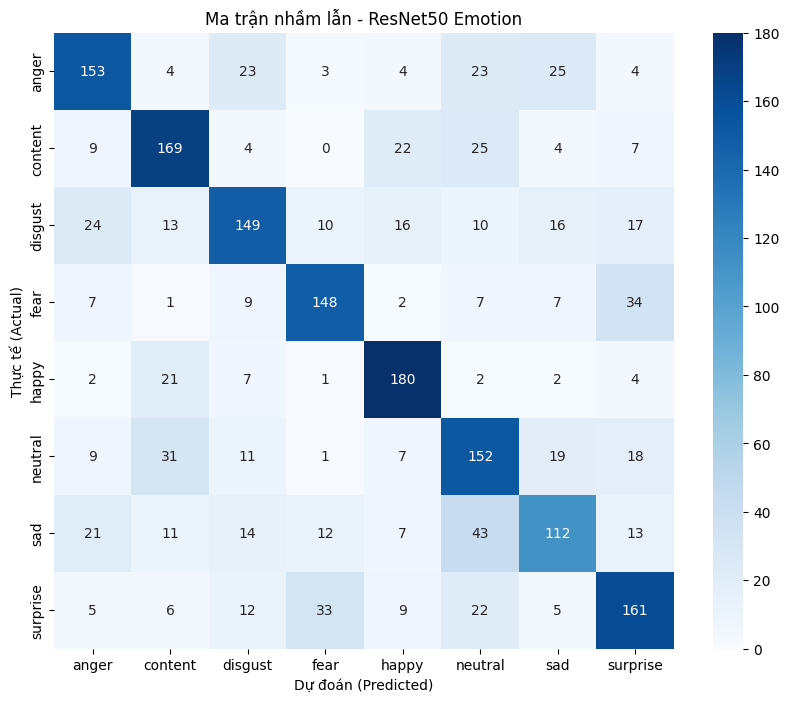


📝 BÁO CÁO CHI TIẾT (Classification Report):
              precision    recall  f1-score   support

       anger       0.67      0.64      0.65       239
     content       0.66      0.70      0.68       240
     disgust       0.65      0.58      0.62       255
        fear       0.71      0.69      0.70       215
       happy       0.73      0.82      0.77       219
     neutral       0.54      0.61      0.57       248
         sad       0.59      0.48      0.53       233
    surprise       0.62      0.64      0.63       253

    accuracy                           0.64      1902
   macro avg       0.65      0.65      0.64      1902
weighted avg       0.64      0.64      0.64      1902

✅ Xong! Hãy tải 2 file: 'confusion_matrix_resnet.png' và 'classification_report.txt' về máy.


In [4]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

DATA_DIR = '/kaggle/input/dataset-mat-cat' 
MODEL_PATH = '/kaggle/input/mytrainedmodel/resnet50_emotion_finetuned.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'valid'), data_transforms)
dataloader = DataLoader(image_dataset, batch_size=32, shuffle=False)
class_names = image_dataset.classes

model = models.resnet50(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, len(class_names))
)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Dự đoán (Predicted)')
plt.ylabel('Thực tế (Actual)')
plt.title('Ma trận nhầm lẫn - ResNet50 Emotion')
plt.savefig('confusion_matrix_resnet.png') # Lưu ảnh
plt.show()

report = classification_report(all_labels, all_preds, target_names=class_names)
print("\n📝 BÁO CÁO CHI TIẾT (Classification Report):")
print(report)

with open('classification_report.txt', 'w') as f:
    f.write(report)

print("✅ Xong! Hãy tải 2 file: 'confusion_matrix_resnet.png' và 'classification_report.txt' về máy.")